# Abc about tensorflow
Symbolic math "language"
You write z = x + y 

and then compile(z)

and then compute z for x=4, y=7


In [1]:
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

z = x+y

result = sess.run([z],feed_dict={x:[4],y:[7]})
print(result)

[array([ 11.], dtype=float32)]


# Why not compute them directly?
Because we can compile them for CUDA, for CPU, or on N CUDA + M CPUs, etc.

We need to build a compute graph that will be compiled by the (nv|g)cc compiler. So you write python but execute C.

# Let's classify sth! First, get the dataset:

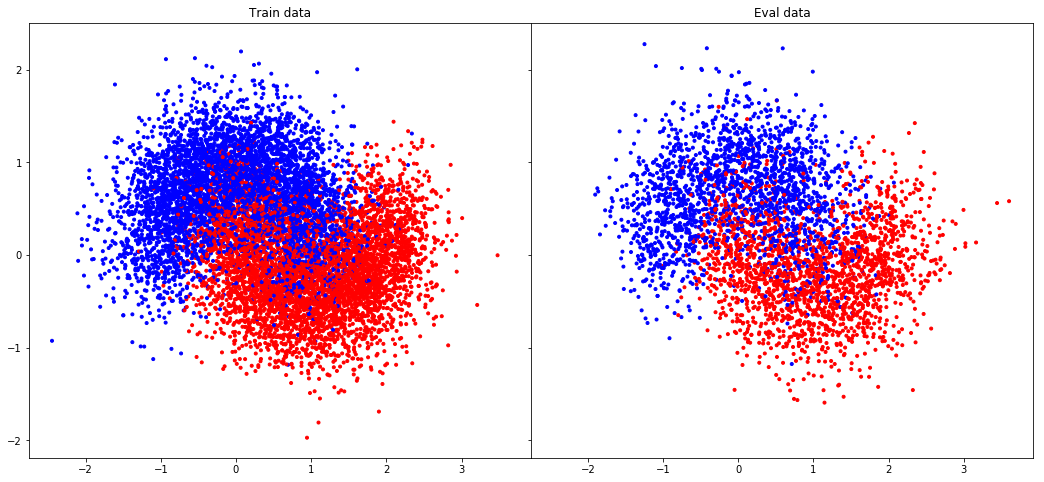

In [26]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from matplotlib.colors import ListedColormap
import sklearn.datasets
import keras.layers as l
import keras.models
from keras.utils.np_utils import to_categorical
import keras.callbacks as callbacks
import shutil
import sklearn.metrics as skm
import os

col2 = ListedColormap(['#0000FF', '#FF0000'])

tb_logdir = '/home/visoft/work/tf/tft/tb_log/'
shutil.rmtree(tb_logdir)
os.mkdir(tb_logdir)

tb_log_simple = callbacks.TensorBoard(log_dir=os.path.join(tb_logdir,"logreg"),
                               histogram_freq=1,write_graph=True, write_images=False)


tb_log_complex = callbacks.TensorBoard(log_dir=os.path.join(tb_logdir,"complex"),
                               histogram_freq=1,write_graph=True, write_images=False)


def plot_data(X,Y,ax=None,title=None):
    """
    Utility func to plot points
    """
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
    ax.scatter(X[:,0],X[:,1],c=Y,cmap=col2,marker='.',linewidths=1,alpha=1)
    if title is not None:
        ax.set_title(title)
    if ax is None:
        plt.show(fig)

def plot_decbounds(X,model,ax):
    """
    Utility func to plot decision boundaries
    """
    x1,x2=np.meshgrid(np.arange(np.min(X[:,0]),np.max(X[:,0]+0.05),0.05),np.arange(np.min(X[:,1]),np.max(X[:,1]+0.05),0.05))
    xd = np.stack([x1.ravel(),x2.ravel()],axis=1)
    yd = model.predict(xd)
#     yd = yd[:,1]
    yd = yd.reshape(x1.shape)
    ax.contourf(x1,x2,yd,cmap=col2,alpha=0.3,levels=np.linspace(0,1,17))


def from_preds_to_labels(preds):
#     pred_class = np.argmax(preds,axis=1)    
    pred_class = (preds >= 0.5).astype(np.uint8)
    return pred_class
    
def eval_perf(gt,pred_proba,msg):
    preds = from_preds_to_labels(pred_proba)
    acc = skm.accuracy_score(gt,preds)
    log = skm.log_loss(gt,pred_proba)
    print("{}: accuracy: {:.2f}, log-loss: {:.5f}".format(msg,acc * 100,log))
    return acc,log

def plot_learning_curves(tr,te):
    fig = plt.figure(figsize=(18,8))
    fig.gca().plot(tr,label="train")
    fig.gca().plot(te,label="test")
    plt.legend()
    fig.show()

NOISE_LEVEL = 0.38  # 0.38    
    
X,Y = sklearn.datasets.make_moons(10000, shuffle=True, noise = NOISE_LEVEL)
Xt,Yt = sklearn.datasets.make_moons(4000, shuffle=True, noise = NOISE_LEVEL)
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data")
plot_data(Xt,Yt,ax[1],"Eval data")

# Build a 1 neuron NN (that is, a logistic regression, a linear boundary)
https://www.google.ro/search?q=logistic+regression+neuron&source=lnms&tbm=isch&sa=X&ved=0ahUKEwj8nIyPhMzUAhVjCZoKHX_OCjYQ_AUICigB&biw=1855&bih=966

In [5]:
print("\n".join(["{:.4f}\t{:.4f}\t{}".format(X[k,0],X[k,1],Y[k]) for k in range(10)]))

0.9207	0.4132	0
-0.4181	0.9118	0
-0.8587	0.5150	0
0.5045	-0.3611	1
-0.1375	0.9872	0
-0.7142	0.7080	0
1.7895	-0.1178	1
0.7698	-0.4722	1
0.2805	0.9610	0
1.9704	0.2647	1


In [6]:
model = keras.models.Sequential()
model.add(l.Dense(1,input_dim=(2)))
model.add(l.Activation('sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
log_train = [];log_test=[]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1)             3           dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1)             0           dense_1[0][0]                    
Total params: 3
Trainable params: 3
Non-trainable params: 0
____________________________________________________________________________________________________


In [7]:
model.fit(X,Y,batch_size=32,nb_epoch=1,verbose=0)

In [8]:
Ypred = model.predict(Xt)
Ypred1 = from_preds_to_labels(Ypred)
print("Shape of the predicted array: {}".format(Ypred.shape))
print("Prediction  Class")
print("\n".join(["{:.4f}\t{}".format (a[0],b[0]) for (a,b) in zip(Ypred[:10,:],Ypred1[:10])]))
eval_perf(Y,model.predict(X),"Train set")
eval_perf(Yt,model.predict(Xt),"Test set ")

Shape of the predicted array: (4000, 1)
Prediction  Class
0.5632	1
0.7033	1
0.7253	1
0.5629	1
0.4561	0
0.7172	1
0.5903	1
0.7244	1
0.4760	0
0.4422	0
Train set: accuracy: 30.30, log-loss: 0.85432
Test set : accuracy: 30.38, log-loss: 0.85477


(0.30375000000000002, 0.85477034573256971)

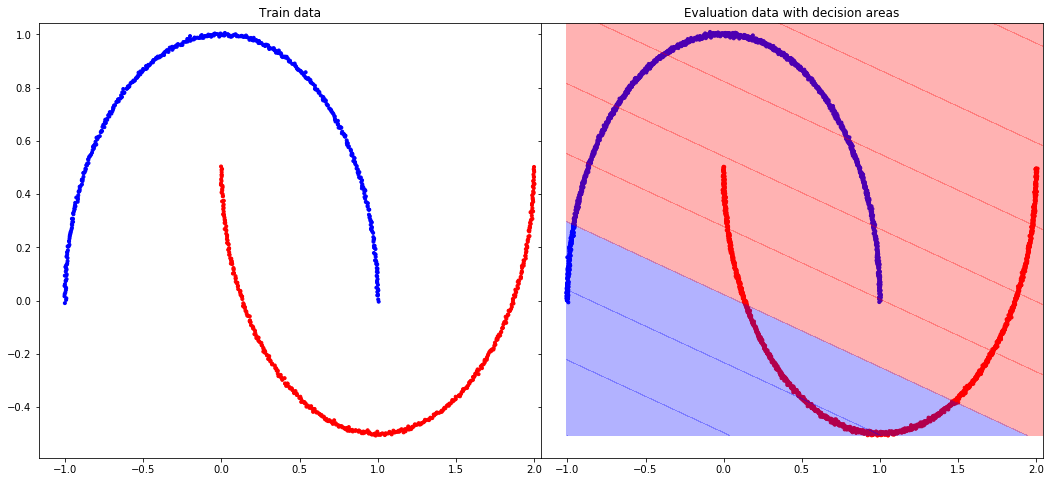

In [9]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data")
plot_data(Xt,Yt,ax[1],"Evaluation data with decision areas")
plot_decbounds(Xt,model,ax[1])

Iteration: 0
Train set: accuracy: 43.30, log-loss: 0.71846
Test set : accuracy: 43.38, log-loss: 0.71872
Iteration: 1
Train set: accuracy: 54.50, log-loss: 0.62256
Test set : accuracy: 54.47, log-loss: 0.62266
Iteration: 2
Train set: accuracy: 63.30, log-loss: 0.55522
Test set : accuracy: 63.45, log-loss: 0.55519
Iteration: 3
Train set: accuracy: 68.80, log-loss: 0.50649
Test set : accuracy: 68.83, log-loss: 0.50635
Iteration: 4
Train set: accuracy: 72.30, log-loss: 0.46957
Test set : accuracy: 72.15, log-loss: 0.46934
Iteration: 5
Train set: accuracy: 74.40, log-loss: 0.44063
Test set : accuracy: 74.55, log-loss: 0.44031
Iteration: 6
Train set: accuracy: 76.20, log-loss: 0.41713
Test set : accuracy: 76.33, log-loss: 0.41674
Iteration: 7
Train set: accuracy: 77.70, log-loss: 0.39728
Test set : accuracy: 77.72, log-loss: 0.39682
Iteration: 8
Train set: accuracy: 79.00, log-loss: 0.37990
Test set : accuracy: 79.15, log-loss: 0.37938
Iteration: 9
Train set: accuracy: 80.00, log-loss: 0.36

/home/visoft/miniconda3/envs/tf/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


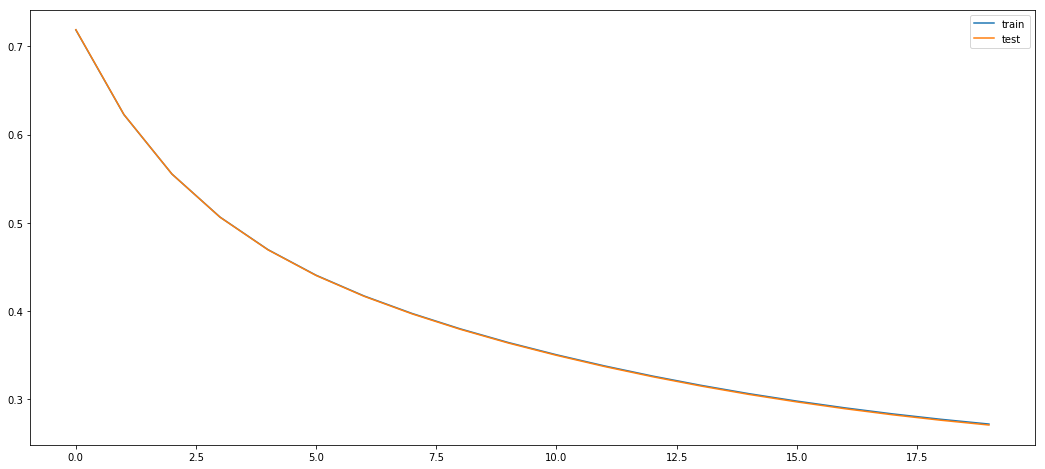

In [10]:
for k in range(20):
    model.fit(X,Y,batch_size=32,nb_epoch=10,verbose=0)
    print("Iteration: {}".format(k))
    _,ll = eval_perf(Y,model.predict(X),"Train set");log_train.append(ll)
    _,ll = eval_perf(Yt,model.predict(Xt),"Test set ");log_test.append(ll)
plot_learning_curves(log_train,log_test)  

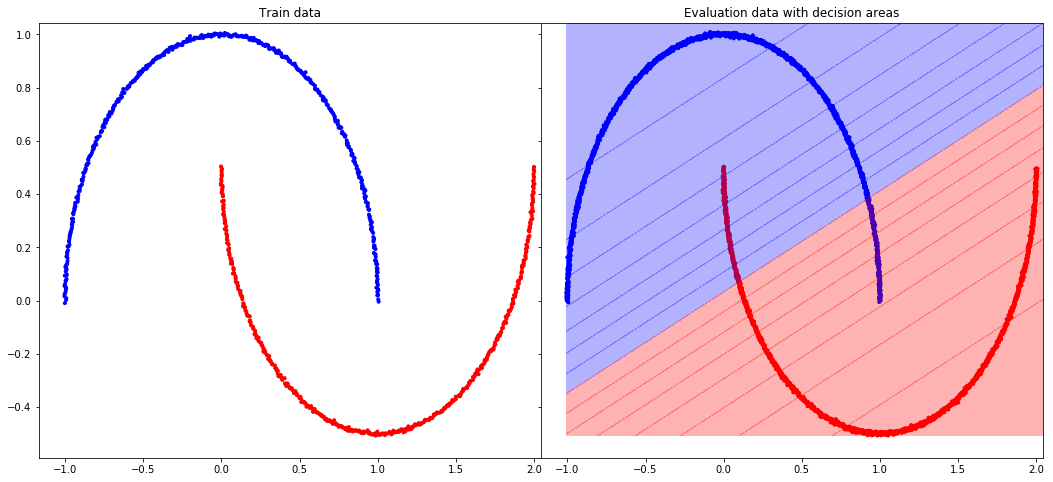

In [11]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data")
plot_data(Xt,Yt,ax[1],"Evaluation data with decision areas")
plot_decbounds(Xt,model,ax[1])
plt.show(fig)

# Ramp things up! More layers! Mwahahaha!
 - go wide
 - go deep
 - go deeper and demo overfitting 
 
https://www.google.ro/search?q=logistic+regression+neuron&source=lnms&tbm=isch&sa=X&ved=0ahUKEwj8nIyPhMzUAhVjCZoKHX_OCjYQ_AUICigB&biw=1855&bih=966#tbm=isch&q=multilayer+perceptron&imgrc=08I2-R9bHBLncM:

In [27]:
model2 = keras.models.Sequential()
model2.add(l.Dense(45,activation='relu',input_dim=2,name="dense_1"))
model2.add(l.Dense(55,activation='relu',name="dense_2"))
model2.add(l.Dense(55,activation='relu',name="dense_3"))
model2.add(l.Dense(55,activation='relu',name="dense_4"))
model2.add(l.Dense(35,activation='relu',name="dense_5"))
model2.add(l.Dense(55,activation='relu',name="dense_6"))

model2.add(l.Dense(1,activation='sigmoid',name="sigmoid_layer"))

model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()
log_train = [];log_test=[]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 45)            135         dense_input_7[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 55)            2530        dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 55)            3080        dense_2[0][0]                    
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 55)            3080        dense_3[0][0]                    
___________________________________________________________________________________________

In [28]:
for k in range(20):
    model2.fit(X,Y,batch_size=32,nb_epoch=10,verbose=0)
    print("Iteration: {}".format(k))
    _,ll = eval_perf(Y,model2.predict(X),"Train set");log_train.append(ll)
    _,ll = eval_perf(Yt,model2.predict(Xt),"Test set ");log_test.append(ll)
plot_learning_curves(log_train,log_test)    

Iteration: 0
Train set: accuracy: 86.71, log-loss: 0.31001
Test set : accuracy: 86.70, log-loss: 0.31064
Iteration: 1
Train set: accuracy: 86.87, log-loss: 0.30406
Test set : accuracy: 86.50, log-loss: 0.30672
Iteration: 2
Train set: accuracy: 86.92, log-loss: 0.30374
Test set : accuracy: 86.78, log-loss: 0.30591
Iteration: 3
Train set: accuracy: 86.98, log-loss: 0.30400
Test set : accuracy: 86.80, log-loss: 0.30647
Iteration: 4
Train set: accuracy: 87.03, log-loss: 0.30263
Test set : accuracy: 86.95, log-loss: 0.30642
Iteration: 5
Train set: accuracy: 87.05, log-loss: 0.30571
Test set : accuracy: 86.88, log-loss: 0.31171
Iteration: 6
Train set: accuracy: 87.07, log-loss: 0.29997
Test set : accuracy: 86.95, log-loss: 0.30532
Iteration: 7
Train set: accuracy: 86.91, log-loss: 0.30149
Test set : accuracy: 86.72, log-loss: 0.30588
Iteration: 8
Train set: accuracy: 87.10, log-loss: 0.30053
Test set : accuracy: 86.72, log-loss: 0.30772
Iteration: 9
Train set: accuracy: 87.03, log-loss: 0.30

KeyboardInterrupt: 

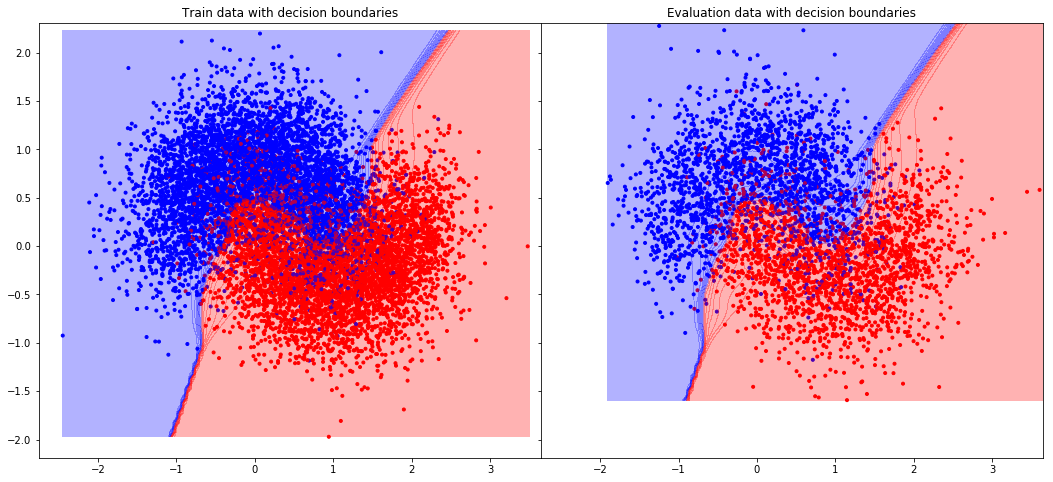

In [29]:
Ypred3 = from_preds_to_labels(model2.predict(X))
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data with decision boundaries")
plot_decbounds(X,model2,ax[0])
plot_data(Xt,Yt,ax[1],"Evaluation data with decision boundaries")
plot_decbounds(Xt,model2,ax[1])
plt.show(fig)

### Create conda env and install tensorflow
    conda create -y -n tf --copy python=3.5 numpy scipy scikit-learn scikit-image opencv pytest h5py joblib matplotlib jupyter pip
    source activate tf
    export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-0.12.1-cp35-cp35m-linux_x86_64.whl
    pip install $TF_BINARY_URL
    pip install keras

### Start notebook 

    jupyter notebook
    
### Start tensorboard
    
    tensorboard --logdir=tb_log --reload_interval 1
    
## Resources to learn stuff:
 - http://www.fast.ai/  Take fast.ai MOOC. Really awesome! Deep learning in Excel! (no joking) I would start with this one!
 - http://neuralnetworksanddeeplearning.com/ Nice and smooth start. A little to much math.
 - Coursera and Udacity lectures
 - For specific tutorials and datasets, take a look at past Kaggle competitions.
 - http://deeplearning.net/ Collection of resources, slightly outdated but still relevant